In [1]:
import pandas as pd
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# word by freq 
# wordcloud


In [2]:
import pandas as pd
import numpy as np 
import re

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn

# spacy for lemmatization
import spacy
import scipy.sparse
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm")

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shawn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz
#!pip install pyLDAvis

In [4]:
df = pd.read_csv('aftercovid.csv')
df.head() #Filter by dates and then keep text?

df = df[["Date","text"]]

df["Year"] = df["Date"].str.split("-").str[2]



# drop 
# groupby year 
# LDA 
# bert 

In [5]:
df

Date                                               text Year
0      26-Nov-20  A freehold semi-detached house at 61 Jalan Kel...   20
1      23-Nov-20  A 4,822 sq ft unit at luxury condo, Nassim Par...   20
2      22-Nov-20  vinz said:\r\nWrote to HDB in OCT 2020 to get ...   20
3      18-Nov-20  Wrote to HDB in OCT 2020 to get a confirmation...   20
4      28-Oct-20  Assuming price and location is the same, would...   20
...          ...                                                ...  ...
19357  29-Nov-20  The price of 1 bedder in D19 for example, pric...   20
19358  25-Nov-20  angrymonster said:\n324k to 397k\n\nStack 123 ...   20
19359  25-Nov-20  Is it true that top floor units are taller in ...   20
19360  22-Nov-20  glorfindel said:\nDepends the walls and window...   20
19361  27-Nov-20  Two adjoining shophouses at 44 & 46 Bukit Paso...   20

[19362 rows x 3 columns]

In [6]:
df["Year"].value_counts()

20    9276
21    7134
22    2952
Name: Year, dtype: int64

In [7]:
df_assigned = df

In [8]:
df_assigned = df_assigned.reset_index(drop=True)

# Data cleaning

In [9]:
# Remove non-English words

# remove punc 
df_assigned['clean_text']  = df_assigned['text'].map(lambda x: re.sub("[^A-Za-z0-9]+"," ", str(x)))
# lower case
df_assigned['clean_text']  = df_assigned['clean_text'].apply(lambda x: x.lower())
# tokenize
df_assigned['clean_text']  = [word_tokenize(row) for row in df_assigned['clean_text']]

# remove stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def remove_stopwords(text):
    return [w for w in text if w not in stop_words]
df_assigned['clean_text']  = df_assigned['clean_text'].apply(lambda x: remove_stopwords(x))


In [10]:
# lemmatization & noun extraction 

def lemmatization(text, allowed_postags=['NOUN']): 
    doc = nlp(' '.join(text)) 
    text_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return text_out

df_assigned['clean_text'] = df_assigned['clean_text'].apply(lambda x: lemmatization(x))


df_assigned.head()

Date                                               text Year  \
0  26-Nov-20  A freehold semi-detached house at 61 Jalan Kel...   20   
1  23-Nov-20  A 4,822 sq ft unit at luxury condo, Nassim Par...   20   
2  22-Nov-20  vinz said:\r\nWrote to HDB in OCT 2020 to get ...   20   
3  18-Nov-20  Wrote to HDB in OCT 2020 to get a confirmation...   20   
4  28-Oct-20  Assuming price and location is the same, would...   20   

                                          clean_text  
0  [house, market, knight, singapore, estate, mar...  
1  [sq, ft, unit, luxury, condo, nassim, park, re...  
2  [vinz, oct, confirmation, eligibility, bto, re...  
3  [oct, confirmation, eligibility, bto, resale, ...  
4          [price, location, year, size, year, size]

In [11]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed texts together
description_str = ''
for word_list in df_assigned['clean_text'].values:
    description_str += ' '.join(row for row in word_list) + ' '

description_str

'house market knight singapore estate marketing agent sale storey house plot sq metre frontage kelawar price translate land rate psf https www edgeprop property ne arezone utm campaign sq ft unit luxury condo nassim park residence market price tag psf https www edgeprop property ne arezone utm campaign vinz oct confirmation eligibility bto resale grant key resale grant conclusion oct email couple resale grant year jan bto november completion date reason course flat online forum discussion matter grant hdb resale application bto ec place year doubt matter sop reply part question reply enquiry hdb mr xxx enquiry oct reply eligibility condition applicant occupier august reply thing owner resale flat market fulfil minimum occupation period year sell wish hdb delivery possession date edpd expiry year resale year period date possession resale edpd hdb period resale computation year mop oct confirmation eligibility bto resale grant key resale grant conclusion oct email couple resale grant yea

In [12]:
new_stop_words = stopwords.words('english')
# new_stop_words += ['recipe','time', 'dish']

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = new_stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
# wordcloud.to_file("wordcloud_after_covid.png")



# Topic Modeling for Text


## Create Corpus 

In [13]:
data_lemmatized = df_assigned['clean_text'].tolist()
print(data_lemmatized[:10])

[['house', 'market', 'knight', 'singapore', 'estate', 'marketing', 'agent', 'sale', 'storey', 'house', 'plot', 'sq', 'metre', 'frontage', 'kelawar', 'price', 'translate', 'land', 'rate', 'psf', 'https', 'www', 'edgeprop', 'property', 'ne', 'arezone', 'utm', 'campaign'], ['sq', 'ft', 'unit', 'luxury', 'condo', 'nassim', 'park', 'residence', 'market', 'price', 'tag', 'psf', 'https', 'www', 'edgeprop', 'property', 'ne', 'arezone', 'utm', 'campaign'], ['vinz', 'oct', 'confirmation', 'eligibility', 'bto', 'resale', 'grant', 'key', 'resale', 'grant', 'conclusion', 'oct', 'email', 'couple', 'resale', 'grant', 'year', 'jan', 'bto', 'november', 'completion', 'date', 'reason', 'course', 'flat', 'online', 'forum', 'discussion', 'matter', 'grant', 'hdb', 'resale', 'application', 'bto', 'ec', 'place', 'year', 'doubt', 'matter', 'sop', 'reply', 'part', 'question', 'reply', 'enquiry', 'hdb', 'mr', 'xxx', 'enquiry', 'oct', 'reply', 'eligibility', 'condition', 'applicant', 'occupier', 'august', 'reply'

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [15]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, 'agent'), (1, 'arezone'), (2, 'campaign'), (3, 'edgeprop'), (4, 'estate'), (5, 'frontage'), (6, 'house'), (7, 'https'), (8, 'kelawar'), (9, 'knight'), (10, 'land'), (11, 'market'), (12, 'marketing'), (13, 'metre'), (14, 'ne'), (15, 'plot'), (16, 'price'), (17, 'property'), (18, 'psf'), (19, 'rate'), (20, 'sale'), (21, 'singapore'), (22, 'sq'), (23, 'storey'), (24, 'translate'), (25, 'utm'), (26, 'www'), (27, 'condo'), (28, 'ft'), (29, 'luxury'), (30, 'nassim'), (31, 'park'), (32, 'residence'), (33, 'tag'), (34, 'unit'), (35, 'applicant'), (36, 'application'), (37, 'august'), (38, 'bto'), (39, 'completion'), (40, 'computation'), (41, 'conclusion'), (42, 'condition'), (43, 'confirmation'), (44, 'couple'), (45, 'course'), (46, 'date'), (47, 'delivery'), (48, 'discussion'), (49, 'doubt')]

Total Vocabulary Size: 10034


## Building LDA Model

### Hyperparameter Tuning for LDA Model

In [16]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    perplexity = lda_model.log_perplexity(corpus)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [17]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.5539148739895977
Perplexity Score:  -7.071272152025801

topic number:  3
Coherence Score:  0.5479037757724514
Perplexity Score:  -7.006542456775213

topic number:  4
Coherence Score:  0.5652050297694718
Perplexity Score:  -7.018119132132847

topic number:  5
Coherence Score:  0.5546532391446015
Perplexity Score:  -7.0039076172309285

topic number:  6
Coherence Score:  0.5659532783437137
Perplexity Score:  -7.001990491034488

topic number:  7
Coherence Score:  0.5540647757956333
Perplexity Score:  -7.031671958679873

topic number:  8
Coherence Score:  0.553121095700745
Perplexity Score:  -7.067781334952913

topic number:  9
Coherence Score:  0.5687726522130796
Perplexity Score:  -7.136140968821959

topic number:  10
Coherence Score:  0.5471660058252487
Perplexity Score:  -7.1855088535001554

topic number:  11
Coherence Score:  0.5671489695820007
Perplexity Score:  -7.346616926661691

topic number:  12
Coherence Score:  0.5555435240275243
Perplexity S

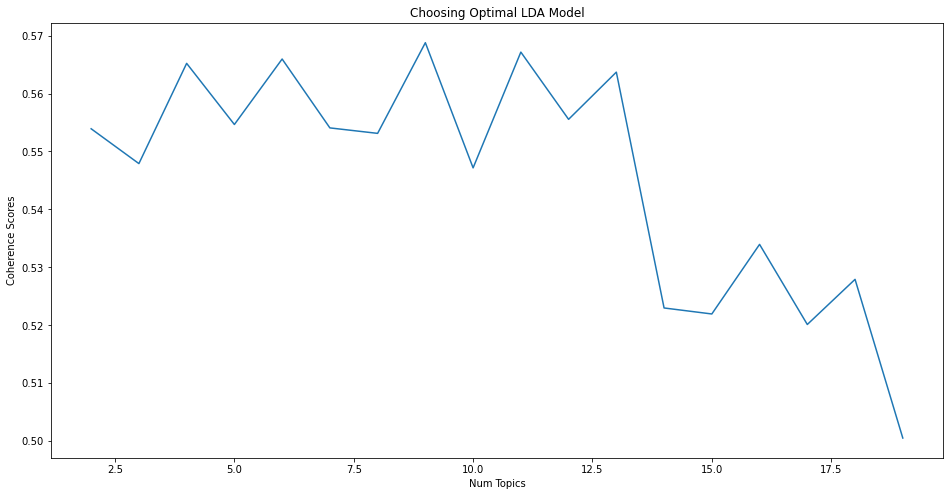

In [18]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

### Final LDA Model

In [31]:
ntopics_des_name = 12

lda_model_des_name = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=ntopics_des_name, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       per_word_topics=True)

In [32]:
# Print the Keyword in the topics
pprint(lda_model_des_name.print_topics())
doc_lda = lda_model_des_name[corpus]

[(0,
  '0.170*"school" + 0.056*"kid" + 0.041*"km" + 0.033*"parent" + 0.023*"family" '
  '+ 0.022*"child" + 0.020*"place" + 0.017*"people" + 0.013*"friend" + '
  '0.013*"time"'),
 (1,
  '0.089*"project" + 0.078*"psf" + 0.070*"developer" + 0.070*"launch" + '
  '0.047*"price" + 0.037*"unit" + 0.029*"buyer" + 0.023*"sale" + '
  '0.015*"pricing" + 0.014*"market"'),
 (2,
  '0.041*"bto" + 0.033*"hdb" + 0.026*"flat" + 0.025*"www" + 0.023*"housing" + '
  '0.019*"com" + 0.019*"https" + 0.017*"singapore" + 0.016*"property" + '
  '0.016*"year"'),
 (3,
  '0.038*"year" + 0.028*"house" + 0.025*"u" + 0.024*"cpf" + 0.020*"loan" + '
  '0.020*"interest" + 0.019*"hdb" + 0.019*"cash" + 0.015*"bank" + '
  '0.014*"resale"'),
 (4,
  '0.027*"u" + 0.027*"rcr" + 0.024*"rental" + 0.023*"ccr" + 0.022*"capital" + '
  '0.022*"penrose" + 0.021*"yield" + 0.020*"nishizhu" + 0.020*"appreciation" + '
  '0.018*"kovan"'),
 (5,
  '0.106*"mrt" + 0.030*"mall" + 0.029*"area" + 0.028*"bus" + 0.026*"station" + '
  '0.023*"min" +

In [33]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [34]:
topic_num = []
print(lda_model_des_name.get_document_topics(corpus))
for n in range(len(df_assigned)):
    get_document_topics = lda_model_des_name.get_document_topics(corpus[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    all_topic = []
    for i in sorted_doc_topics:
        all_topic.append(i[0])
    topic_num.append(all_topic)

In [35]:
df_assigned['Topic'] = topic_num

In [36]:
df_assigned

Date                                               text Year  \
0      26-Nov-20  A freehold semi-detached house at 61 Jalan Kel...   20   
1      23-Nov-20  A 4,822 sq ft unit at luxury condo, Nassim Par...   20   
2      22-Nov-20  vinz said:\r\nWrote to HDB in OCT 2020 to get ...   20   
3      18-Nov-20  Wrote to HDB in OCT 2020 to get a confirmation...   20   
4      28-Oct-20  Assuming price and location is the same, would...   20   
...          ...                                                ...  ...   
19357  29-Nov-20  The price of 1 bedder in D19 for example, pric...   20   
19358  25-Nov-20  angrymonster said:\n324k to 397k\n\nStack 123 ...   20   
19359  25-Nov-20  Is it true that top floor units are taller in ...   20   
19360  22-Nov-20  glorfindel said:\nDepends the walls and window...   20   
19361  27-Nov-20  Two adjoining shophouses at 44 & 46 Bukit Paso...   20   

                                              clean_text  \
0      [house, market, knight, singapore, estate, mar...   
1      [sq, ft, unit, luxury, condo, nassim, park, re...   
2      [vinz, oct, confirmation, eligibility, bto, re...   
3      [oct, confirmation, eligibility, bto, resale, ...   
4              [price, location, year, size, year, size]   
...                                                  ...   
19357  [price, bedder, d19, example, price, 850k, eg,...   
19358              [324k, 397k, floor, mrt, floor, 397k]   
19359  [floor, unit, height, floor, plan, brochure, b...   
19360  [glorfindel, wall, window, house, block, sunli...   
19361  [pasoh, market, guide, price, knight, singapor...   

                                        Topic  
0                           [2, 11, 10, 6, 3]  
1                                  [2, 6, 11]  
2                                     [2, 11]  
3                                      [2, 3]  
4      [6, 9, 3, 10, 11, 1, 2, 5, 0, 8, 4, 7]  
...                                       ...  
19357               [9, 3, 5, 1, 4, 8, 6, 10]  
19358  [9, 5, 6, 8, 7, 11, 0, 1, 2, 3, 4, 10]  
19359                               [9, 5, 2]  
19360                     [9, 7, 0, 10, 8, 2]  
19361                                 [2, 11]  

[19362 rows x 5 columns]

In [37]:
des_name_final = df_assigned[['Date', 'text', 'clean_text', 'Topic']]
des_name_final.head()

Date                                               text  \
0  26-Nov-20  A freehold semi-detached house at 61 Jalan Kel...   
1  23-Nov-20  A 4,822 sq ft unit at luxury condo, Nassim Par...   
2  22-Nov-20  vinz said:\r\nWrote to HDB in OCT 2020 to get ...   
3  18-Nov-20  Wrote to HDB in OCT 2020 to get a confirmation...   
4  28-Oct-20  Assuming price and location is the same, would...   

                                          clean_text  \
0  [house, market, knight, singapore, estate, mar...   
1  [sq, ft, unit, luxury, condo, nassim, park, re...   
2  [vinz, oct, confirmation, eligibility, bto, re...   
3  [oct, confirmation, eligibility, bto, resale, ...   
4          [price, location, year, size, year, size]   

                                    Topic  
0                       [2, 11, 10, 6, 3]  
1                              [2, 6, 11]  
2                                 [2, 11]  
3                                  [2, 3]  
4  [6, 9, 3, 10, 11, 1, 2, 5, 0, 8, 4, 7]

In [38]:
des_name_final.to_csv('description_name_features_final_all_noun.csv', index=False) 

### Model Evaluation

In [39]:
# Compute Perplexity
perplexity = lda_model_des_name.log_perplexity(corpus)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_des_name, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -7.7683461815321175
Coherence Score:  0.5337709600584705


## Visualisation

In [40]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# # feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

In [41]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_des_name, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.106780 -0.177892       1        1  16.723043
10     0.197708 -0.058579       2        1  12.587427
3      0.179735  0.062709       3        1  10.751188
5     -0.187249  0.153913       4        1   9.732404
8     -0.231629  0.016035       5        1   8.889498
9     -0.077172  0.013489       6        1   8.239775
2      0.212648 -0.026690       7        1   7.512005
6     -0.258390 -0.095230       8        1   6.982483
1     -0.071109 -0.298839       9        1   6.242562
0      0.087283  0.208542      10        1   5.260336
4      0.066276 -0.005075      11        1   4.027409
7     -0.024882  0.207619      12        1   3.051870, topic_info=        Term          Freq         Total Category  logprob  loglift
285   school   5108.000000   5108.000000  Default  30.0000  30.0000
34      unit  11675.000000  11675.000000  Default  29.0000  29.0000
137      mrt   8853.000000   8853.000000  Default  28.0000  28.0000
16     price  12060.000000  12060.000000  Default  27.0000  27.0000
18       psf   5390.000000   5390.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
732     east    136.709795    724.948966  Topic12  -4.8472   1.8212
1031    shop    125.821909    678.989508  Topic12  -4.9302   1.8037
823   choice    129.300623    962.710531  Topic12  -4.9029   1.4818
189      day    125.006583   1695.447510  Topic12  -4.9367   0.8821
1134    liao    118.427034    697.247255  Topic12  -4.9907   1.7166

[716 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4111      3  0.989570     10yr
1655      3  0.990242     150k
2601      1  0.995425     15xx
2516      1  0.983222  1600psf
2490      1  0.995055     16xx
...     ...       ...      ...
87        8  0.054905     year
87        9  0.009340     year
87       10  0.044555     year
87       11  0.003787     year
249      11  0.997933    yield

[1290 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 11, 4, 6, 9, 10, 3, 7, 2, 1, 5, 8])

## Word Count of Topic Keywords

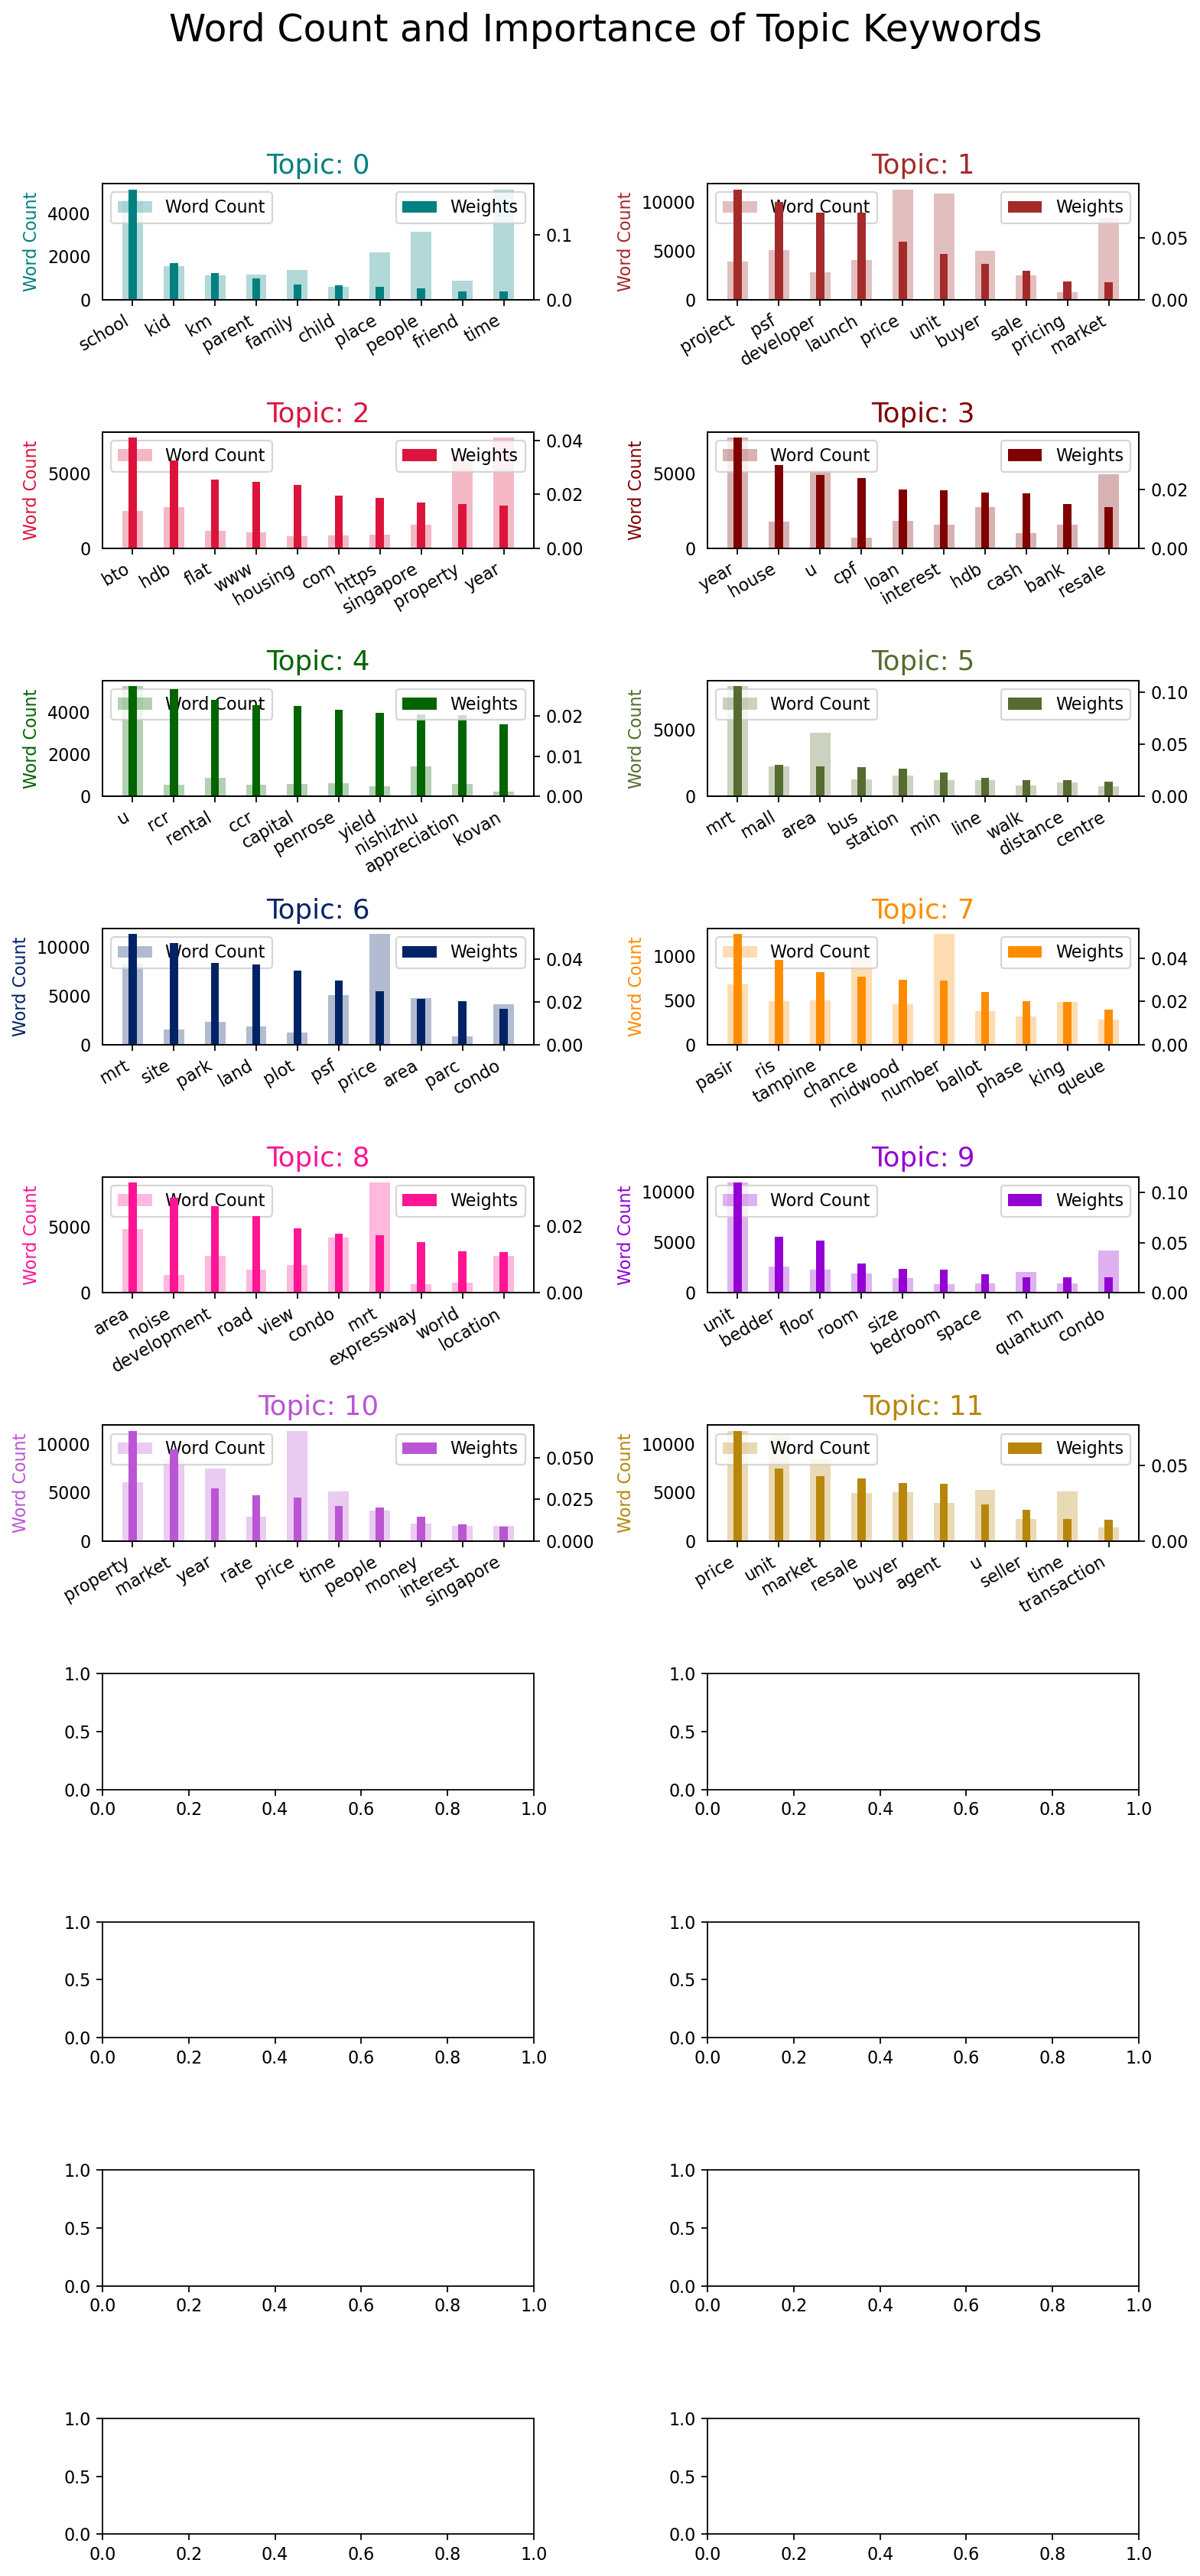

In [42]:
from collections import Counter

topics = lda_model_des_name.show_topics(num_topics=ntopics_des_name, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(10, 2, figsize=(10,20), dpi=160)
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2', '#1b364a']

for i, ax in enumerate(axes.flatten()):
    if i > ntopics_des_name - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()